# Pegasos

Most literature on Support Vector Machines (SVMs) concentrate on
the dual optimization problem. Whereas Pegasos points out that the primal problem itself coud be solved efficiently.

Focus on linear SVM.

### Génération des données

In [159]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
np.random.seed(0)

n_samples, n_features = 10000, 50
X = np.random.randn(n_samples, n_features)
W_real = np.random.randn(n_features) #chgt en maj pour les variables d'entrée
Y = np.sign(X.dot(W_real) + np.random.randn(n_samples))

## Preprocessing the data

#### Normalization
SVM tries to maximize the distance between the separating plane and the support vectors. If one feature (i.e. one dimension in this space) has very large values, it will dominate the other features when calculating the distance. If you rescale all features (e.g. to [0, 1]), they all have the same influence on the distance metric.

In [160]:
from sklearn import preprocessing
X_scale= preprocessing.scale(X)

In [147]:
pd.DataFrame(X_scale).describe()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
count,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,...,1.000000e+04,10000.000000,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04
mean,-3.055334e-17,5.790923e-17,-2.700062e-17,5.044853e-17,-3.108624e-17,2.469136e-17,-3.197442e-17,-4.654055e-17,-1.207923e-17,-8.526513e-18,...,-4.050094e-17,0.000000,-2.557954e-17,4.867218e-17,2.557954e-17,-1.563194e-17,-3.979039e-17,-5.790923e-17,-4.973799e-18,1.421085e-18
std,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,...,1.000050e+00,1.000050,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00
min,-3.528775e+00,-4.241572e+00,-3.748656e+00,-4.807973e+00,-3.447402e+00,-3.845229e+00,-3.653616e+00,-3.475923e+00,-4.263492e+00,-3.993324e+00,...,-4.266787e+00,-3.819606,-3.923899e+00,-3.581164e+00,-3.929283e+00,-4.226381e+00,-4.036770e+00,-3.505275e+00,-3.637163e+00,-4.210649e+00
25%,-6.694925e-01,-6.761657e-01,-6.799790e-01,-6.638791e-01,-6.786848e-01,-6.792431e-01,-6.851165e-01,-6.739504e-01,-6.787010e-01,-6.667995e-01,...,-6.673000e-01,-0.657993,-6.809715e-01,-6.801206e-01,-6.854098e-01,-6.696009e-01,-6.780757e-01,-6.773196e-01,-6.724490e-01,-6.726675e-01
50%,7.968174e-03,-8.385514e-04,-2.149095e-03,-5.008627e-03,5.223925e-03,1.715171e-03,-7.037973e-03,-5.071468e-03,8.124270e-04,-1.792881e-03,...,-2.617707e-03,0.000654,1.019184e-02,-5.271617e-03,-2.715387e-03,3.938627e-03,-4.482148e-03,1.307084e-02,4.099296e-03,8.299609e-03
75%,6.782644e-01,6.710383e-01,6.805330e-01,6.684502e-01,6.774109e-01,6.789516e-01,6.803765e-01,6.760663e-01,6.760136e-01,6.761831e-01,...,6.729562e-01,0.681586,6.919423e-01,6.898613e-01,6.704945e-01,6.704980e-01,6.820260e-01,6.831873e-01,6.807125e-01,6.793582e-01
max,3.400545e+00,3.536183e+00,3.505806e+00,3.751706e+00,3.557642e+00,3.620859e+00,4.055220e+00,3.606643e+00,3.727794e+00,3.899649e+00,...,3.703564e+00,3.461707,3.804062e+00,3.927934e+00,3.806133e+00,3.591497e+00,3.757283e+00,4.401787e+00,3.924877e+00,3.683498e+00


# Understanding the behaviour

### Define framework

#### Functions toolbox

In [3]:
def hinge_loss(x,y,w):
    """
    Compute hinge loss for one observation
    
    Inputs
        w: weight (size n_features)
        x: covariates (size n_features)
        y: outcome (size 1)
    Output
        hinge loss at observation (size 1)
    
    """
    prod= np.dot(x, w)
    return np.maximum(0, 1- y*prod)

def primal(w,X, Y, lamb,loss_funct= hinge_loss):
    '''
    Compute primal suboptimality of the model depending on loss function
    
    Inputs
        w: weight (n_features)
        X: covariates matrix (n_samples*n_features)
        Y: outcome vector (n_samples)
        loss_funct: loss function to consider (default: hinge_loss)
    
    Output
        primal 
    '''
    reg= (lamb/2)*np.linalg.norm(w, ord=2)
    loss = np.mean(loss_funct(X,Y,w))
    return reg + loss


### Setting first hyperparameters

In [100]:
n_epoch = 5
n_iter = n_epoch*n_samples # for comparison purposes

In [101]:
lamb=0.01

### Basic implementation of Pegasos
We want to show first here the behaviour of the basic implementation of Pegasos as described by Shalev-Shwartz et al. (2007). Additionally, the PEGASOS projection step is skipped, as it
can be shown that even without it, $||w||^2 \leq 4/\lambda$ is maintained.

In [102]:
def pegasos_basic(X,Y,lamb, n_iter):
    """
    Implement Pegasos in its basic definition
    In Shalev-Shwartz, Shai, et al. "Pegasos: Primal estimated sub-gradient solver for svm." 
    Mathematical programming 127.1 (2011): 3-30.
    
    Inputs:
        X: covariates matrix (n_samples,n_features) 
        Y: outcome vector, coded as (-1,1), (n_samples)
        lamb: regularization paramater
        n_iter: number of iterations
    
    Outputs:
        primal_: primal suboptimality at each iteration (n_iter)
        rtime: running time for each iteration (n_iter)
        w: final weights (n_features)
    
    """
    m = len(Y) #number of observations
    rtime = [] #keeping track of running time
    
    # Initialisation
    w= np.zeros(n_features) 
    primal_= []


    for i in range(0,n_iter):

        start_time = time.perf_counter()
        
        t=np.random.randint(m) # draw random index
        eta = 1/(lamb*(i+1)) # define step size
        
        # Compute subgradient
        x, y = X[t], Y[t]
        subgrad= y*(w.dot(x))
        
        # Compute weight
        if subgrad <1:
            w=(1-eta*lamb)*w+ (eta*y)*x
        else :
             w=(1-eta*lamb)*w
                
        # Estimate running time
        rtime.append(time.perf_counter() - start_time)
        
        # To monitor the optimization (excluded from rtime)
        cost = primal(w,X,Y,lamb)
        primal_.append(cost)
        
    print("total running time:",sum(rtime), "sec") 
    print("final primal suboptimality:", cost)

    output = namedtuple("output", ["primal", "rtime", "w"])
    out= output(primal_, rtime, w)
    return out
    


In [161]:
result_peg_basic = pegasos_basic(X_scale,Y,lamb,n_iter)

total running time: 4.002757339570962 sec
final primal suboptimality: 0.17202835659839033


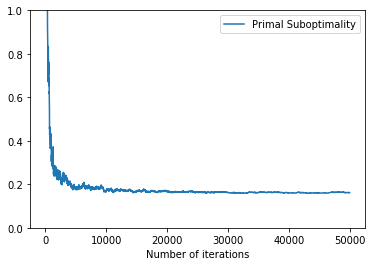

In [162]:
plt.plot(range(0,n_iter),result_peg_basic_scale.primal, label="Primal Suboptimality")
plt.xlabel("Number of iterations")
plt.ylim((0,1))
plt.legend()

### Variant Pegasos
We used a variant of the previous method, with a single example used in each update: Following
Bottou (Web Page), instead of sampling an example independently
at each iteration, a random permutation over the training set
is used. When the permutation is exhausted, a new, independent,
random permutation is drawn. Although this variation does not
match the theoretical analysis, it performs slightly better in practice, as in Shalev-Shwartz, Shai, and Nathan Srebro. "SVM optimization: inverse dependence on training set size." Proceedings of the 25th international conference on Machine learning. ACM, 2008.

**The idea**: performs the subgradient descent over all data points per pass. With this systematic method we avoid bias coming from neglecting a random portion of our dataset.

**Impact on implementation**: we now think in terms of epoch rather than number of iterations


In [153]:
def pegasos_mod(X,Y,lamb, n_epoch): 
    """
    Implement Pegasos in its variant definition
    cf. Bottou.
    Idea: define with regard to pass on the data
    
    Inputs:
        X: covariates matrix (n_samples,n_features) 
        Y: outcome vector, coded as (-1,1), (n_samples)
        lamb: regularization paramater
        n_epoch: number of epoch
    
    Outputs:
        primal_: primal suboptimality at each iteration (n_iter)
        rtime: running time for each iteration (n_iter)
        w: final weights (n_features)
    """
    
    m = len(Y) #number of observations

    primal_= []
    rtime = []
    
    w= np.zeros(n_features) 
    

    
    for i in range(0, n_epoch):
        
        start_time = time.perf_counter() 
        
        # Shuffle datasets
        p= np.random.permutation(m)
        Xs=X[p]
        Ys=Y[p]
        
        # Subgradient descent over all data points
        for t in range(0,m):
            eta = 1/(lamb*(t+1))
            x, y= Xs[t], Ys[t]
            subgrad= y*(w.dot(x))
            if subgrad <1:
                w=(1-eta*lamb)*w+ (eta*y)*x
            else:
                w=(1-eta*lamb)*w
                    
        # Monitor convergence            
        rtime.append(time.perf_counter() - start_time)
        cost = primal(w,X,Y, lamb)
        primal_.append(cost)

        
        
    print("running time:",sum(rtime)) 

    print("final primal suboptimality:", cost)

    output = namedtuple("output", ["primal", "rtime", "w"])
    out= output(primal_, rtime, w)
    return out
        

In [163]:
result_peg_mod = pegasos_mod(X_scale,Y, lamb, n_epoch)

running time: 0.7515393140056403
final primal suboptimality: 0.17833339363121506


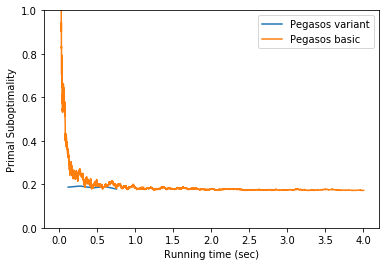

In [164]:
plt.plot(np.cumsum(result_peg_mod.rtime),result_peg_mod.primal, label="Pegasos variant")
plt.plot(np.cumsum(result_peg_basic.rtime),result_peg_basic.primal, label="Pegasos basic")
plt.xlabel("Running time (sec)")
plt.ylabel("Primal Suboptimality")
plt.ylim((0,1))
plt.legend()

#### Running time per iteration
To check if running time is constant across iteration as said in the article

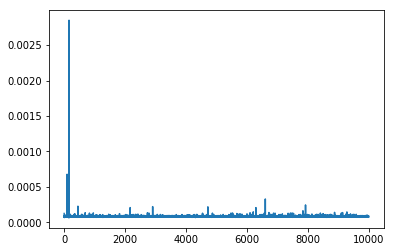

In [81]:
plt.plot(result_peg_basic.rtime) 

### Other variants

Other implementations could have been followed. 

- A *mini-batch* version has been provided in the article. It has been shown that in practice no improvement is to see neither on running time nore in global performance. The only interesting aspect of this implementation is of course for parallelisation purposes but since we didn't plan to adapt our algorithm to this setting, we prefered not to follow this path.
- A *kernelized* version exists for non linear SVM, with Mercier kernels. We prefer for comparison purpose and to handle the basic version to focus on linear SVM.
- Include an *unregularized bias* in the loss which plays a role in unbalanced dataset: according to the authors, including an unregularized bias term does not significantly change the predictive performance for any of their data sets used. Furthermore, SDCA does not incorporate a bias term either. Nonetheless, there are clearly learning problems in specific setting (text processing for example).

## Stopping criteria implementation

### Prendre en compte l'aspet prédictif

Il n'y a pas de critère d'arrêt inclus dans l'agorithme. Afin de pouvoir comparer la performance des algo ona mis en plac un cadre qui permet de jauger de leur performance

Il y a plusieurs possibilités:
- utiliser le nombre d'itération
- calculer des métriques d'arrêt sur le train dans une logique d'optimisation complète de l'algorithme
- caluculer des métriques d'arrêt sur le test pour améliorer l'extrapolation de la prédiction et éviter l'overfitting.

Puisque nous sommes dans le cadre d'une prédiction, nous considérons que le plus important reste dans la généralisation des résultats. D'où des métriques sur le test. Plusieurs possibilités: calcul de

In [6]:
from sklearn.model_selection import train_test_split
from collections import namedtuple


In [50]:
def pegasos_splitted(X,Y,lamb,test_ratio=0.2, stop_thresh=0.01): 
    """
    Following notations in article:
    X: matrix (m,n) (nbr of samples,n of features) 
    Y: outcome vector, size m coded as (-1,1)
    W:
    lamb: paramter for the step size
    rtime: vector, size n_iter, to keep track of running time
    """
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_ratio, shuffle=True, 
                                                        random_state = 0)
    m = len(Y_train) #number of observations
    n_features = X.shape[1] #number of features
    primal_test= []
    primal_train= []
    rtime = []
    
    w= np.zeros(n_features)
    print("Before optimisation")
    print("Primal on train", primal(w,X_train,Y_train, lamb))
    print("Primal on test", primal(w,X_test,Y_test, lamb))


    
    i=0
    diff =50 #initialisation
    
    while (abs(diff) > stop_thresh):
        
        start_time = time.time()

        #Estimation step
        t=np.random.randint(m)
        eta = 1/(lamb*(i+1)) #step length decreasing with iteration (learning rate)
        x, y = X_train[t], Y_train[t]
        subgrad= y*(w.dot(x))
        if subgrad <1:
            w=(1-eta*lamb)*w+ (eta*y)*x
        else :
             w=(1-eta*lamb)*w
        

        # Validation step
        cost_test = primal(w,X_test,Y_test, lamb)
        primal_test.append(cost_test)

        
        
        if i >50:
            diff1 = primal_test[i] - primal_test[i-20]
            diff2 = primal_test[i] - primal_test[i-10]
            diff3 = primal_test[i] - primal_test[i-30]
            diff4 = primal_test[i] - primal_test[i-40]
            diff5 = primal_test[i] - primal_test[i-50]


            diff = np.mean((diff1,diff2,diff3, diff4,diff5))
        
        rtime.append(time.time() - start_time)

        # Monitoring
        cost_train = primal(w,X_train,Y_train,lamb)
        primal_train.append(cost_train)

            
        i+=1

            
    print("total number of iteration:",i) 
    print("running time:",sum(rtime)) 

    print("After optimisation")
    print("Primal on train", primal(w,X_train,Y_train, lamb))
    print("Primal on test", primal(w,X_test,Y_test, lamb))
    output = namedtuple("output", ["primal_test","primal_train", "rtime", "w"])
    out= output(primal_test,primal_train, rtime, w)
    return out
            

In [189]:
def pegasos_iter(X,Y,lamb,n_iter,test_ratio=0.2, stop_thresh=0.01): 
    """
    Following notations in article:
    X: matrix (m,n) (nbr of samples,n of features) 
    Y: outcome vector, size m coded as (-1,1)
    W:
    lamb: paramter for the step size
    rtime: vector, size n_iter, to keep track of running time
    """

    m = len(Y) #number of observations
    n_features = X.shape[1] #number of features
    primal_test= []
    primal_train= []
    rtime = []
    
    w= np.zeros(n_features)
    
    cost_test = 50
    diff =50
    
    for i in range(0,n_iter):
        start_time = time.time()

        #Estimation step
        t=np.random.randint(m)
        eta = 1/(lamb*(i+1)) #step length decreasing with iteration (learning rate)
        x, y = X[t], Y[t]
        subgrad= y*(w.dot(x))
        if subgrad <1:
            w=(1-eta*lamb)*w+ (eta*y)*x
        else :
             w=(1-eta*lamb)*w
        rtime.append(time.time() - start_time)

        # Validation step
        cost_train = primal(w,X,Y,lamb)
        primal_train.append(cost_train)
        



            
    print("total number of iteration:",i)    
    output = namedtuple("output", ["primal_train", "rtime", "w"])
    out= output(primal_train, rtime, w)
    return out
            

### Understanding the learning rate

In [51]:
out1 = pegasos_splitted(X,Y, lamb= 0.1,stop_thresh=0.0001)


Before optimisation
Primal on train 1.0
Primal on test 1.0
total number of iteration: 368
running time: 0.26073169708251953
After optimisation
Primal on train 0.48277362007035857
Primal on test 0.5111143389183614


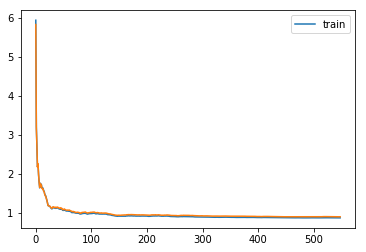

In [187]:
plt.plot(out1.primal_train, label = "train")
plt.plot(out1.primal_test)
plt.legend()

In [190]:
out2 = pegasos_iter(X,Y, lamb= 1,n_iter=1000)


total number of iteration: 999


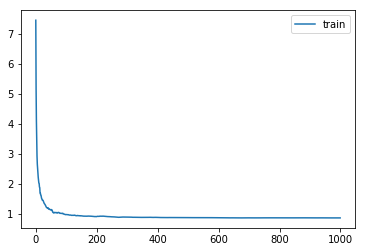

In [192]:
plt.plot(out2.primal_train, label = "train")
plt.legend()

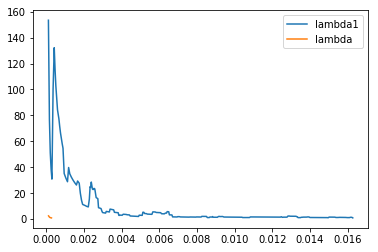

In [152]:
plt.plot(np.cumsum(out2.rtime),out2.primal_test,label= 'lambda1')
plt.plot(np.cumsum(out1.rtime),out1.primal_test, label= 'lambda')
plt.legend(loc='best')

lambda: 0.001
cost_test 76.71423592504631
cost_test 41.49050893906336
cost_test 22.28633596518227
cost_test 19.199332374107826
cost_test 13.236111596745824
cost_test 9.943340644543282
cost_test 11.036337911107388
cost_test 7.752421109596766
cost_test 5.765840134663635
cost_test 3.6181557182903994
cost_test 3.5063259048646533
cost_test 3.3285169651480353
cost_test 2.6706240840413056
cost_test 3.33248124708189
cost_test 3.148564448859169
total number of iteration: 751
lambda: 0.01
cost_test 11.177086195668625
cost_test 2.940265176650385
cost_test 2.4797081163222208
cost_test 1.287102699065932
cost_test 1.2690688061169686
cost_test 1.1055883058330607
cost_test 1.0218278967287593
cost_test 0.7233771021934865
cost_test 0.7149008223275937
cost_test 0.8228101535042855
cost_test 0.7137077682717758
cost_test 0.7624496435954801
cost_test 0.8001593249270987
cost_test 0.7003290378503105
cost_test 0.5682606904999598
cost_test 0.6111357991714241
cost_test 0.5332443260663485
cost_test 0.4639631806107

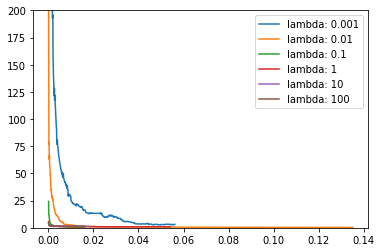

In [161]:
lambdas = [0.001,0.01,0.1,1,10,100]

for l in lambdas: 
    print('lambda: {}'.format(l))
    out = pegasos_splitted(X,Y,l,stop_thresh=0.0001)
    plt.plot(np.cumsum(out.rtime),out.primal_test, label= 'lambda: {}'.format(l))

plt.ylim(0,200)
plt.legend(loc='best')
plt.show()
    

In [156]:
out = pegasos_splitted(X,Y,5)

In [157]:
out.primal_test

[0.7310085406300538]

In [53]:
primal_test, rtime, w =pegasos_splitted(X,Y,lamb)

In [148]:
# Un biais important
np.linalg.norm((out1.w, W_real))

6.586488399075818

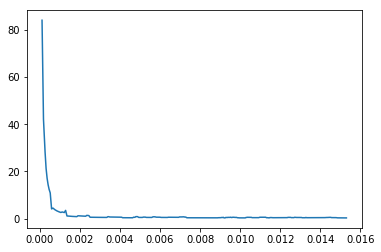

In [57]:
plt.plot(np.cumsum(rtime), primal_test)

In [ ]:
plt.plot(np.cumsum(rtime),loss)

### Arrange Pegasos

In [41]:
def pegasos_bottou(X,Y,lamb, test_ratio=0.2, stop_thresh=0.1 ): 
    """
    Following notations in article:
    X: matrix (m,n) (nbr of samples,n of features) 
    Y: outcome vector, size m coded as (-1,1)
    W:
    lamb: paramter for the step size
    rtime: vector, size n_iter, to keep track of running time
    """
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_ratio, shuffle=True, 
                                                        random_state = 0)
    m = len(Y_train) #number of observations

    n_features = X.shape[1] #number of features
    primal_test= []
    primal_train= []
    rtime = []
    
    w= np.zeros(n_features)

    cost_test = 50
    i=0
    diff1 =50
    
    
    while (abs(diff1) > stop_thresh):
        
        print("epoch:",i) 

        start_time = time.time() 
        
        # Estimation step
        for t in range(0,m):
            eta = 1/(lamb*(t+1)) #step length decreasing with iteration
            x, y= X_train[t], Y_train[t]
            subgrad= y*(w.dot(x))
            if subgrad <1:
                w=(1-eta*lamb)*w+ (eta*y)*x
            else:
                w=(1-eta*lamb)*w
                    

        # Validation step
        cost_test = primal(w,X_test,Y_test, lamb)
        primal_test.append(cost_test)
        cost_train = primal(w,X_train,Y_train,lamb)
        primal_train.append(cost_train)
        
        if i>2:
            diff1 = primal_test[i] - primal_test[i-1]


            print(diff1)

        rtime.append(time.time() - start_time)

        i+=1
        
        
    print("total number of epoch:",i) 
    print("running time:",sum(rtime)) 

    print("After optimisation")
    print("Primal on train", primal(w,X_train,Y_train, lamb))
    print("Primal on test", primal(w,X_test,Y_test, lamb))
    output = namedtuple("output", ["primal_test","primal_train", "rtime", "w"])
    out= output(primal_test,primal_train, rtime, w)
    return out
        

In [43]:
test = pegasos_bottou(X,Y, 0.1,stop_thresh=0.0001)

epoch: 0
epoch: 1
epoch: 2
epoch: 3
0.0
total number of epoch: 4
running time: 0.642418622970581
After optimisation
Primal on train 0.3454171596752686
Primal on test 0.36106376659286354


In [44]:
out1 = pegasos_splitted(X,Y, lamb= 0.1,stop_thresh=0.0001)


Before optimisation
Primal on train 1.0
Primal on test 1.0
total number of iteration: 467
running time: 0.7754514217376709
After optimisation
Primal on train 0.452536376443069
Primal on test 0.4731736600415935


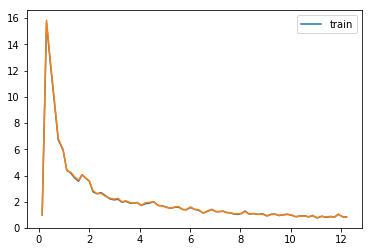

In [24]:
plt.plot(np.cumsum(test.rtime),test.primal_train, label = "train")
plt.plot(np.cumsum(test.rtime),test.primal_test)
plt.legend()


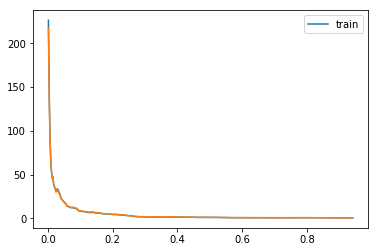

In [55]:
plt.plot(np.cumsum(test1.rtime),test1.primal_train, label = "train")
plt.plot(np.cumsum(test1.rtime),test1.primal_test)
plt.legend()

In [ ]:
primal_pegasos_fast= np.zeros(n_epoch)
for i in range(0,n_epoch):
    w= W_fast[i]
    primal_pegasos[i]=primal(w,X,Y)

In [ ]:
primal_pegasos_fast

In [ ]:
W_fast

# Results

In [62]:
Y

array([ 1., -1.,  1., ...,  1., -1.,  1.])

In [75]:
y_pred1 = np.sign(X.dot(test.w))
y_pred2 = np.sign(X.dot(test1.w))

In [76]:
from sklearn.metrics import f1_score
print("f1 Bottou",f1_score(Y, y_pred1))
print("f1 normal",f1_score(Y, y_pred2))

f1 Bottou 0.6503740648379053
f1 normal 0.8226727022239716


In [77]:
from sklearn.metrics import confusion_matrix
confusion_matrix(Y, y_pred2)

array([[4018,  935],
       [ 867, 4180]])

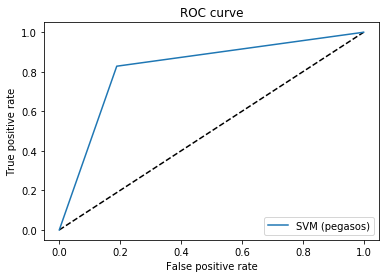

In [83]:
from sklearn import metrics
fpr, tpr, _ =metrics.roc_curve(Y, y_pred2)
#roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='SVM (pegasos)')

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.show()

In [85]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets


def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy

In [91]:
X0, X1 = X[:, 0], X[:, 1] 

In [87]:
X0, X1 = Xi[:, 0], Xi[:, 1] #deux variables continues

In [89]:
X0

array([5.1, 4.9, 4.7, 4.6, 5. , 5.4, 4.6, 5. , 4.4, 4.9, 5.4, 4.8, 4.8,
       4.3, 5.8, 5.7, 5.4, 5.1, 5.7, 5.1, 5.4, 5.1, 4.6, 5.1, 4.8, 5. ,
       5. , 5.2, 5.2, 4.7, 4.8, 5.4, 5.2, 5.5, 4.9, 5. , 5.5, 4.9, 4.4,
       5.1, 5. , 4.5, 4.4, 5. , 5.1, 4.8, 5.1, 4.6, 5.3, 5. , 7. , 6.4,
       6.9, 5.5, 6.5, 5.7, 6.3, 4.9, 6.6, 5.2, 5. , 5.9, 6. , 6.1, 5.6,
       6.7, 5.6, 5.8, 6.2, 5.6, 5.9, 6.1, 6.3, 6.1, 6.4, 6.6, 6.8, 6.7,
       6. , 5.7, 5.5, 5.5, 5.8, 6. , 5.4, 6. , 6.7, 6.3, 5.6, 5.5, 5.5,
       6.1, 5.8, 5. , 5.6, 5.7, 5.7, 6.2, 5.1, 5.7, 6.3, 5.8, 7.1, 6.3,
       6.5, 7.6, 4.9, 7.3, 6.7, 7.2, 6.5, 6.4, 6.8, 5.7, 5.8, 6.4, 6.5,
       7.7, 7.7, 6. , 6.9, 5.6, 7.7, 6.3, 6.7, 7.2, 6.2, 6.1, 6.4, 7.2,
       7.4, 7.9, 6.4, 6.3, 6.1, 7.7, 6.3, 6.4, 6. , 6.9, 6.7, 6.9, 5.8,
       6.8, 6.7, 6.7, 6.3, 6.5, 6.2, 5.9])

In [92]:
xx, yy = make_meshgrid(X0, X1)

In [ ]:
np.sign(X.dot(test.w))

In [126]:
nd_array = np.ndarray(shape=(2, n_samples),dtype=float)
nd_array.shape

(2, 10000)

In [131]:
xx.ravel().shape

(255990,)

In [124]:
nd_array[0] = xx
nd_array[1] = yy

ValueError: could not broadcast input array from shape (483,530) into shape (10000)

In [120]:
(xx,yy).dot(test1.w[0:2])

AttributeError: 'tuple' object has no attribute 'dot'

In [110]:
X[:,0:2].shape

(10000, 2)

In [118]:
def plot_contours( xx, yy):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = np.sign(X[.dot(test1.w[0:2]))
    Z = Z.reshape(xx.shape)
    out = plt.contourf(xx, yy, Z, **params)
    return out

In [86]:
# import some data to play with
iris = datasets.load_iris()
# Take the first two features. We could avoid this by using a two-dim dataset
Xi = iris.data[:, :2]
yi= iris.target

In [ ]:
# we create an instance of SVM and fit out data. We do not scale our
# data since we want to plot the support vectors
C = 1.0  # SVM regularization parameter
models = (svm.SVC(kernel='linear', C=C),
          svm.LinearSVC(C=C),
          svm.SVC(kernel='rbf', gamma=0.7, C=C),
          svm.SVC(kernel='poly', degree=3, C=C))
models = (clf.fit(X, y) for clf in models)

In [ ]:
# title for the plots
titles = ('SVC with linear kernel',
          'LinearSVC (linear kernel)',
          'SVC with RBF kernel',
          'SVC with polynomial (degree 3) kernel')

In [ ]:
# Set-up 2x2 grid for plotting.
fig, sub = plt.subplots(2, 2)
plt.subplots_adjust(wspace=0.4, hspace=0.4)

In [ ]:
for clf, title, ax in zip(models, titles, sub.flatten()):
    plot_contours(ax, clf, xx, yy,
                  cmap=plt.cm.coolwarm, alpha=0.8)
    ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel('Sepal length')
    ax.set_ylabel('Sepal width')
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)

plt.show()

In [119]:
plt.figure()
plot_contours(xx, yy)
plt.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
plt.set_xlim(xx.min(), xx.max())
plt.set_ylim(yy.min(), yy.max())
plt.set_xlabel('Sepal length')
plt.set_ylabel('Sepal width')
plt.set_xticks(())
plt.set_yticks(())
plt.set_title(title)


ValueError: cannot reshape array of size 10000 into shape (483,530)